https://www.tensorflow.org/tutorials/generative/autoencoder?hl=ko

https://blog.keras.io/building-autoencoders-in-keras.html

https://www.kaggle.com/a7madmostafa/denoising-images-using-conv-autoencoders

를 참고하였다.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

from sklearn.model_selection import train_test_split

In [12]:
path = '/content/drive/MyDrive/Colab Notebooks/Denoising Astral Photos'

img_list = sorted(os.listdir(path + '/X'))
cleaned_img_list = sorted(os.listdir(path + '/y'))

In [13]:
# prepare function
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (280, 280))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (280, 280, 1))
    
    return img

In [14]:
# preprocess images
train = []
train_cleaned = []

for f in sorted(os.listdir(path + '/X')):
    train.append(process_image(path + '/X/' + f))

for f in sorted(os.listdir(path + '/y')):
    train_cleaned.append(process_image(path + '/y/' + f))

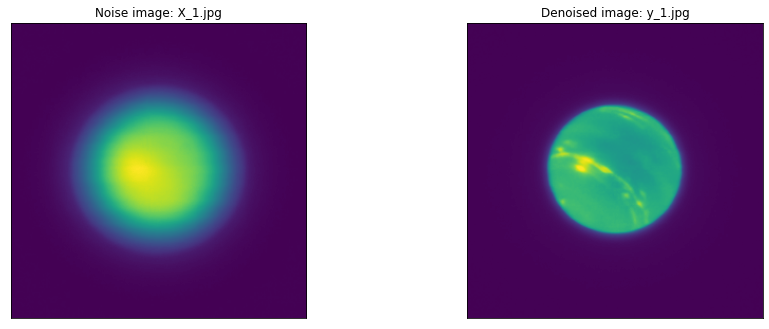

In [15]:
plt.figure(figsize=(15,25))
for i in range(1):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0])
    plt.title('Noise image: {}'.format(img_list[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0])
    plt.title('Denoised image: {}'.format(cleaned_img_list[i]))

plt.show()

In [16]:
# convert list to numpy array
X_train = np.asarray(train)
y_train = np.asarray(train_cleaned)
X_val = X_train
y_val = y_train

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1)

In [17]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, losses
from keras.callbacks import EarlyStopping
from keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing

In [18]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = keras.Sequential([
            layers.InputLayer(input_shape=[280, 280, 1]),
            #preprocessing.RandomRotation(factor=0.15),
            layers.Conv2D(128, (3,3), activation='relu', padding='same'),
            layers.MaxPool2D((2,2), padding='same'),
            layers.Conv2D(64, (3,3), activation='relu', padding='same'),
            layers.MaxPool2D((2,2), padding='same'),
            
        ])
        
        self.decoder = keras.Sequential([        
            layers.Conv2DTranspose(64, (3,3), strides = 2, activation='relu', padding='same'),
            layers.Conv2DTranspose(128, (3,3), strides = 2, activation='relu', padding='same'),
            layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')
        ])
    
    def call(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode

In [19]:
autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

history = autoencoder.fit(X_train, y_train,
                epochs=200,
                batch_size=16,
                shuffle=True,
                validation_data=(X_val, y_val),
                callbacks=[early_stopping])

Epoch 1/200
1/1 [==============================] - 1s 619ms/step - loss: 0.1982 - val_loss: 0.1965
Epoch 2/200
1/1 [==============================] - 0s 40ms/step - loss: 0.1965 - val_loss: 0.1944
Epoch 3/200
1/1 [==============================] - 0s 38ms/step - loss: 0.1944 - val_loss: 0.1918
Epoch 4/200
1/1 [==============================] - 0s 42ms/step - loss: 0.1918 - val_loss: 0.1886
Epoch 5/200
1/1 [==============================] - 0s 40ms/step - loss: 0.1886 - val_loss: 0.1844
Epoch 6/200
1/1 [==============================] - 0s 38ms/step - loss: 0.1844 - val_loss: 0.1790
Epoch 7/200
1/1 [==============================] - 0s 41ms/step - loss: 0.1790 - val_loss: 0.1720
Epoch 8/200
1/1 [==============================] - 0s 43ms/step - loss: 0.1720 - val_loss: 0.1629
Epoch 9/200
1/1 [==============================] - 0s 41ms/step - loss: 0.1629 - val_loss: 0.1510
Epoch 10/200
1/1 [==============================] - 0s 38ms/step - loss: 0.1510 - val_loss: 0.1359
Epoch 11/200
1/1 [

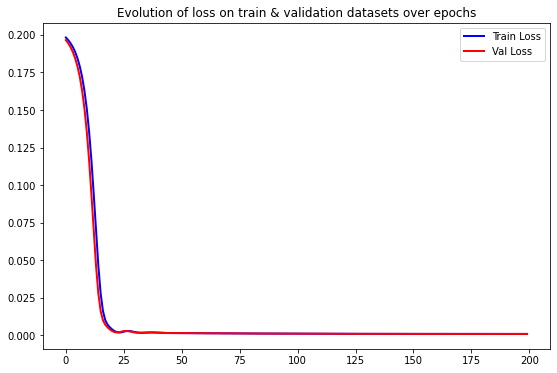

In [21]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [22]:
y_pred = autoencoder.predict(X_test, batch_size=16)

NameError: ignored

In [ ]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(y_pred[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_img[i]))

plt.show()